In [10]:
import numpy as np
import cvxpy as cvx
import matplotlib.pyplot as plt
from lava_one_step import main as lava_problem

In [11]:
# Definition of Fano bound
def bound_Fano(R_perp, I):
    return -(I+np.log(1+R_perp))/np.log(1-R_perp)

def kl_inverse(q, c):
    '''
    Compute kl inverse using Relative Entropy Programming
    Solves: sup p in [0,1] with KL(p,q) <= c
    '''   
    p_bernoulli = cvx.Variable(2)

    q_bernoulli = np.array([q,1-q])

    constraints = [c >= cvx.sum(cvx.kl_div(p_bernoulli,q_bernoulli)), 0 <= p_bernoulli[0], p_bernoulli[0] <= 1, p_bernoulli[1] == 1.0-p_bernoulli[0]]

    prob = cvx.Problem(cvx.Maximize(p_bernoulli[0]), constraints)

    # Solve problem
    prob.solve(verbose=False, solver=cvx.MOSEK) # solver=cvx.MOSEK
    
    return p_bernoulli.value[0] 


def compute_RI(nx, nu, ny, T, p0, px_x, py_x, R, R0_expected):
	'''
    One step Fano bound (T=1)
    '''
	# Compute R_perp
	R_u = p0 @ R
	Rt_perp = np.max(R_u)

    # Compute mutual information
	px_0 = p0 # Probability of x_0
	pyx_0 = py_x*px_0[None,:]  # pyx(i,j) is probability of measurement i and state j 
	py_0 = np.sum(pyx_0, 1)

	I = 0.0
	for ii in range(0,ny):
		for jj in range(0,nx):
			if (np.abs(pyx_0[ii,jj]) > 1e-5):
				# mutual information using KL divergence
				I = I + pyx_0[ii,jj]*np.log(pyx_0[ii,jj]/(py_0[ii]*px_0[jj]))
	
	return Rt_perp, I



### Compute our bound for one-step lava problem

In [12]:
# One-step Lava Problem: Our bounds
p_correct_vals = np.linspace(0.01, 0.99, 20) 
reward_xs = np.array([0.1]) 
reward_x = reward_xs[0]
bounds = []
for p_correct in p_correct_vals:
    nx, nu, ny, T, p0, px_x, py_x, R, R0_expected = lava_problem(['--p_correct', str(p_correct), '--reward_x', str(reward_x)])
    Rt_perp, I = compute_RI(nx, nu, ny, T, p0, px_x, py_x, R, R0_expected) 
    bound_inverse = kl_inverse(Rt_perp, I)
    bounds.append(bound_inverse)


### Generalized Fano's Inequality
$R_\text{Bayes}$: Bayesian risk \
$L$: Loss function \
$I$: Mutual information \
$\theta \in\Theta$: Parameter describing data, $x\sim\mathcal X \sim P_\theta$ \
$w$: Prior distribution of true parameter $\theta$ 

$$R_\text{Bayes} (w) \geq 1+\frac{I(w,\mathcal P)+\log 2}{\log(\sup_{a\in\mathcal A}w\{\theta\in\Theta:L(\theta,a)=0\})}$$

$$1+\frac{\mathbb I+\log(1+R^\perp)}{\log(1-R^\perp}\leq \inf_\pi\mathbb E[C_\pi]$$

Setting $C_\pi=1-R_\pi, \sup_\pi R_\pi = 1-\inf_\pi C_\pi$,

$$1+\frac{\mathbb I+\log(1+R^\perp)}{\log(1-R^\perp}\leq \inf_\pi\mathbb E[C_\pi]=1-\sup_\pi \mathbb E [R_\pi]\\\sup_\pi \mathbb E [R_\pi]\leq\frac{\mathbb I+\log(1+R^\perp)}{\log(1/(1-R^\perp)}$$

In [13]:
# One-step Lava Problem: Fano bounds

bounds_Fano = []
for p_correct in p_correct_vals:
    nx, nu, ny, T, p0, px_x, py_x, R, R0_expected = lava_problem(['--p_correct', str(p_correct), '--reward_x', str(reward_x)])
    Rt_perp, I = compute_RI(nx, nu, ny, T, p0, px_x, py_x, R, R0_expected) 
    Fano_b = bound_Fano(Rt_perp, I)
    bounds_Fano.append(Fano_b)

In [7]:
from lava_problem_pomdp_one_step import main as lava_problem_pomdp
opt_values = []
for p_correct in p_correct_vals:
    opt_value = lava_problem_pomdp(['--p_correct', str(p_correct), '--reward_x', str(reward_x)])
    opt_values.append(opt_value)

***Computing value via POMDP solution***
Optimal value:  0.325
Optimal cost:  0.675
***Computing value via POMDP solution***
Optimal value:  0.325
Optimal cost:  0.675
***Computing value via POMDP solution***
Optimal value:  0.32499999999999996
Optimal cost:  0.675
***Computing value via POMDP solution***
Optimal value:  0.32500000000000007
Optimal cost:  0.6749999999999999
***Computing value via POMDP solution***
Optimal value:  0.325
Optimal cost:  0.675
***Computing value via POMDP solution***
Optimal value:  0.32500000000000007
Optimal cost:  0.6749999999999999
***Computing value via POMDP solution***
Optimal value:  0.325
Optimal cost:  0.675
***Computing value via POMDP solution***
Optimal value:  0.325
Optimal cost:  0.675
***Computing value via POMDP solution***
Optimal value:  0.325
Optimal cost:  0.675
***Computing value via POMDP solution***
Optimal value:  0.32500000000000007
Optimal cost:  0.6749999999999999
***Computing value via POMDP solution***
Optimal value:  0.325
Op

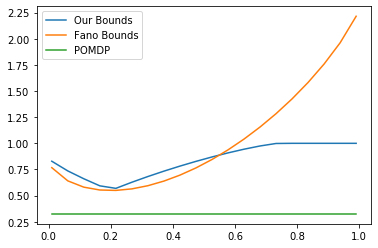

In [14]:
plt.plot(p_correct_vals,bounds, label='Our Bounds')
plt.plot(p_correct_vals,bounds_Fano, label='Fano Bounds')
plt.plot(p_correct_vals,opt_values,label='POMDP')
plt.legend()

In [24]:
np.savez('results/compare_Fano.npz', p_correct_vals = p_correct_vals, our_bounds = bounds, Fano_bounds = bounds_Fano, POMDP_bounds = opt_values)

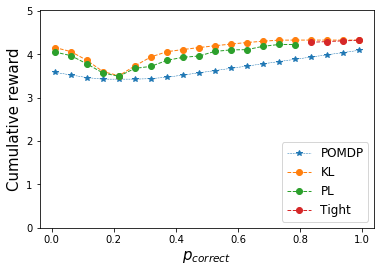

In [18]:
# Plot
# Load x-axis and POMDP data
opt_data = np.load("results/lava_problem_optimal_results.npz")
opt_values = opt_data['opt_values']

KL_data = np.load("results/lava_problem_Kullback_Leibler_results_f.npz")
KL_values = KL_data['bounds']

PL_data = np.load("results/results5_0921.npz")
PL_values = PL_data['bound_results']

tight_data = np.load("results/tightest_bounds.npz")
tight_values = tight_data['bounds']

fig, ax = plt.subplots()
ax.plot(p_correct_vals, opt_values, '*--', label='POMDP', linewidth=0.5)
ax.plot(p_correct_vals, KL_values, 'o--', label='KL', linewidth=1)
ax.plot(p_correct_vals[:16], PL_values[:16],  'o--', label='PL', linewidth=1)
ax.plot(p_correct_vals[16:20], tight_values[16:20], 'o--', label='Tight', linewidth=1)

plt.xlabel('$p_{correct}$', fontsize=15)
plt.ylabel('Cumulative reward', fontsize=15)
plt.legend(fontsize=12, loc='lower right')
plt.ylim([0, 5.01])
plt.savefig('plots/PL_n=5_1006.svg', dpi=200)